**Python Version   : 2.7.11** <br>
**Ipython Version  : 4.0.1**

In [51]:
try:
    import ipy_table
except ImportError, e:
    !pip install ipy_table
    
import os
import six
import gzip
import pylab
import cPickle
import traitlets
import numpy as np
from ipy_table import *
from itertools import izip as zip, count
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# let's embed the plots in the notebook itself
%matplotlib inline

In [52]:
# Load the dataset
f = gzip.open('data/mnist.pkl.gz', 'rb')

# 50,000 , 10,000, 10,000 images
train_set, valid_set, test_set = cPickle.load(f)
f.close()

# An array of 50,000 images, each image is itself an array of 784 values (gray scale between 0 and 1)
training_inputs = [np.reshape(x, (1, 784)) for x in train_set[0]]

# 50,000  integers that encode the corresponding labels 
training_results = [y for y in train_set[1]]

In [54]:
def set_mnist_pos_neg(positive_label, negative_label):
    """
    Generates postitive and negative classes based on the provided labels
    
    Arguments:
    
    positive_label -- digit for the positive class
    negative_label -- digit for the negative class 
    
    Returns:
    
    Returns images with postive and negative labels    
    """
    positive_indices = [i for i, j in zip(count(), training_results) if j == positive_label]
    negative_indices = [i for i, j in zip(count(), training_results) if j == negative_label]
    
    pos_images = [ training_inputs[index] for index in positive_indices ]
    neg_images = [ training_inputs[index] for index in negative_indices ]
    
    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(pos_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(neg_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()
    
    return pos_images, neg_images

In [55]:
def training_slideshow_10(step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(averages)), averages)
    pylab.plot(step, averages[step], "bo")
    pylab.show()

In [56]:
def train_perceptron(positive_samples, negative_samples, num_iterations = 100):
    """
    Trains a perceptron
    
    Arguments:
    
    positive_samples -- ndarray (num_samples, num_dims) of data points from the positive class
    negative_samples -- ndarray (num_samples, num_dims) of data points from the negative class

    Keyword arguments:
    
    num_iterations -- Number of iterations to run the algorithm.
    
    Returns:
    
    List of snapshots in the form [(step, weights_0, confusion_matrix_0), (weights_1, confusion_matrix_1), ...]    
    """
    num_dims = np.shape(positive_samples[0])[1]
    print num_dims
    
    # initialise the weights
    weights = np.zeros((num_dims,1))  
    
    pos_count = np.shape(positive_samples)[0]
    neg_count = np.shape(negative_samples)[0]

    np.set_printoptions(precision=2, suppress=True)
    report_frequency = max(num_iterations / 100, 1)
    
    snapshots = []

    for i in six.moves.range(num_iterations):
        # select a positive and a negative example
        pos = positive_samples[i]
        neg = negative_samples[i]

        # present the positive example
        pos_out = np.dot(pos, weights)
               
        if pos_out < 0:
            # if there was a mistake, update the weights
            weights = weights + pos.reshape(weights.shape)

        # present the negative example
        neg_out = np.dot(neg, weights)
        if neg_out >= 0:
            # if there was a mistake, update the weights
            weights = weights - neg.reshape(weights.shape)
                        
        pos_out = np.dot(positive_samples, weights)
        neg_out = np.dot(negative_samples, weights)        

        pos_correct = (pos_out >= 0).sum() / float(pos_count)
        neg_correct = (neg_out < 0).sum() / float(neg_count)

        confusion_matrix = np.zeros((2,2))
        confusion_matrix[0,0] = pos_correct
        confusion_matrix[0,1] = 1 - pos_correct
        confusion_matrix[1,1] = neg_correct
        confusion_matrix[1,0] = 1 - neg_correct
            
        #print np.average(confusion_matrix.diagonal())
                        
        snapshots.append((np.copy(weights), confusion_matrix))            

    return snapshots

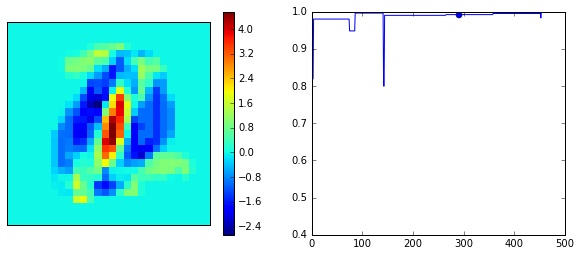

In [57]:
positive_images, negative_images = set_mnist_pos_neg(1, 0)

snapshots = train_perceptron(positive_images, negative_images, 500)     
averages = [np.average(confusion_matrix.diagonal()) for (weights, confusion_matrix) in snapshots]

interact(training_slideshow_10, step=widgets.IntSlider(value=0, min=0, max=len(snapshots) - 1))

####  This does well. Could this be due to the fact that 1s and 0s are visually different?  Hmm...Let's try 2 & 5 in the next example. 